In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.get_device_name(0))  # Name of the GPU

True
1
Tesla T4


In [2]:
!nvidia-smi


Thu Feb 27 10:04:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN

fatal: destination path 'PyTorch-GAN' already exists and is not an empty directory.


In [5]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.3 MB/s eta 0:00:00
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.1+cu124
    Uninstalling torchaudio-2.5.1+cu124:
      Successfully uninstalled torchaudio-2.5.1+cu124


In [6]:
%cd PyTorch-GAN

/content/PyTorch-GAN


In [7]:
!ls

assets	data  implementations  LICENSE	README.md  requirements.txt


In [8]:
pip install -r requirements.txt

In [9]:
!pip uninstall torchvision -y
!pip install torchvision --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torchvision 0.21.0+cu118
Uninstalling torchvision-0.21.0+cu118:
  Successfully uninstalled torchvision-0.21.0+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-linux_x86_64.whl (6.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 requires torch<2.6,>=1.10, but you have torch 2.6.0+cu118 which is incompatible.


In [10]:
%cd implementations/acgan


/content/PyTorch-GAN/implementations/acgan


In [11]:
nvidia-smi

NameError: name 'nvidia' is not defined

In [12]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Configure data loader for CelebA
transform = transforms.Compose([
    transforms.Resize(64),            # Resize the image
    transforms.CenterCrop(64),        # Crop to the desired size
    transforms.ToTensor(),            # Convert to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize
])

# Load the dataset
celeba_dataset = datasets.CelebA(
    root="../../data/celeba",
    split="train",
    download=True,
    transform=transform
)

# Create a dataloader
dataloader = DataLoader(celeba_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

# Function to denormalize images for display
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization (from [-1, 1] to [0, 1])
    return img.clamp(0, 1)

# Get a batch of images and labels
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Plot a grid of the first 8 images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()

for img, ax in zip(images[:8], axes):
    img = denormalize(img)  # Undo normalization
    ax.imshow(img.permute(1, 2, 0))  # Rearrange dimensions for display (C, H, W -> H, W, C)
    ax.axis('off')

plt.tight_layout()
plt.show()


FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

SyntaxError: invalid decimal literal (<ipython-input-14-00af83cf8dca>, line 1)

In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

# Check for CUDA
cuda = True if torch.cuda.is_available() else False

# CelebA dataset directory (Google Drive recommended)
DATASET_PATH = "./data/celeba"

# Ensure dataset directory exists
os.makedirs(DATASET_PATH, exist_ok=True)

# Choose an attribute index (between 0 and 39 for CelebA)
attribute_index = 0  # Example: "5_o_Clock_Shadow"

# Define transformations
transform = transforms.Compose([
    transforms.Resize(64),  # Resize to match the model input size
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

# Load CelebA dataset with attribute labels
dataset = datasets.CelebA(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=transform,
    target_type=['attr']  # This loads attribute labels
)

# Extract a specific attribute (convert attributes to labels)
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, attribute_index):
        self.dataset = dataset
        self.attribute_index = attribute_index

    def __getitem__(self, index):
        img, attributes = self.dataset[index]
        label = attributes[self.attribute_index].item()  # Get specific attribute
        return img, label

    def __len__(self):
        return len(self.dataset)

# Wrap the CelebA dataset to extract only the chosen attribute
filtered_dataset = CelebADataset(dataset, attribute_index)

# Create DataLoader
dataloader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)

# Check dataset
for batch in dataloader:
    imgs, labels = batch
    print(f"Batch Shape: {imgs.shape}, Labels Shape: {labels.shape}")
    break


FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

In [ ]:
# Original code imports remain the same
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

# Create the images directory
os.makedirs("images", exist_ok=True)

# Argument parser setup
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=10, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of CPU threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=2, help="number of classes (binary classification for celeb attributes)")
parser.add_argument("--img_size", type=int, default=64, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels (RGB)")
parser.add_argument("--sample_interval", type=int, default=200, help="interval between image sampling")
opt = parser.parse_args([])  # No command-line arguments passed
print(opt)

cuda = True if torch.cuda.is_available() else False

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)
        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity, label

# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader for CelebA
os.makedirs("../../data/celeba", exist_ok=True)

# Modify the data loading to only use one specific attribute
# Choose an attribute index between 0 and 39 (inclusive)
attribute_index = 0

# Create the DataLoader
dataloader = torch.utils.data.DataLoader(
    datasets.CelebA(
        root="../../data/celeba",
        split="train",
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(opt.img_size),
                transforms.CenterCrop(opt.img_size),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        ),
        # Pass target_type as a list with the desired attribute
        target_type=['attr']
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def sample_image(n_row, batches_done):
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    labels = np.array([num % opt.n_classes for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)


Namespace(n_epochs=10, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, n_classes=2, img_size=64, channels=3, sample_interval=200)


FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

In [ ]:
from torch_fidelity import calculate_metrics
import torch
import os
import numpy as np
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Create directories for real and generated images if they don't exist
os.makedirs("real_imgs", exist_ok=True)
os.makedirs("gen_imgs", exist_ok=True)

# Lists for tracking metrics
generator_loss_list = []
discriminator_loss_list = []
inception_scores = []
fid_scores = []
classification_accuracies = []

# Training loop
for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        labels = labels[:, attribute_index]  # Extract the specific attribute if multi-label
        batch_size = imgs.shape[0]

        # Labels for real and fake images
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Load real images and labels
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # ---- Train Generator ----
        optimizer_G.zero_grad()

        # Sample noise and labels for generator
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate images
        gen_imgs = generator(z, gen_labels)
        validity, pred_label = discriminator(gen_imgs)

        # Calculate generator loss
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))
        g_loss.backward()
        optimizer_G.step()

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()

        # Real images loss
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Fake images loss
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Calculate classification accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        # Append losses for tracking
        generator_loss_list.append(g_loss.item())
        discriminator_loss_list.append(d_loss.item())
        classification_accuracies.append(d_acc)

        # Print training information
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
        )

        # Save sample images at intervals
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)

    # ---- Save images for FID calculation ----
    for i in range(real_imgs.size(0)):
        save_image(real_imgs[i], f"real_imgs/{epoch}_{i}.png")
    for i in range(gen_imgs.size(0)):
        save_image(gen_imgs[i], f"gen_imgs/{epoch}_{i}.png")

    # ---- Calculate FID ----
    metrics = calculate_metrics(input1="real_imgs", input2="gen_imgs", fid=True)
    fid_score = metrics.get('frechet_inception_distance', 'FID not computed')
    fid_scores.append(fid_score)
    print("FID Score:", fid_score)

    # ---- Plot Metrics ----
    if epoch % 5 == 0 or epoch == opt.n_epochs - 1:  # Plot every 5 epochs or at the end
        # Losses
        plt.figure(figsize=(10, 5))
        plt.plot(generator_loss_list, label="Generator Loss")
        plt.plot(discriminator_loss_list, label="Discriminator Loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.title("Generator and Discriminator Loss over Epoch")
        plt.legend()
        plt.show()


        # Classification Accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(classification_accuracies, label="Discriminator Accuracy", color="green")
        plt.xlabel("Batch")
        plt.ylabel("Accuracy")
        plt.title("Discriminator Classification Accuracy Over Epoch")
        plt.legend()
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

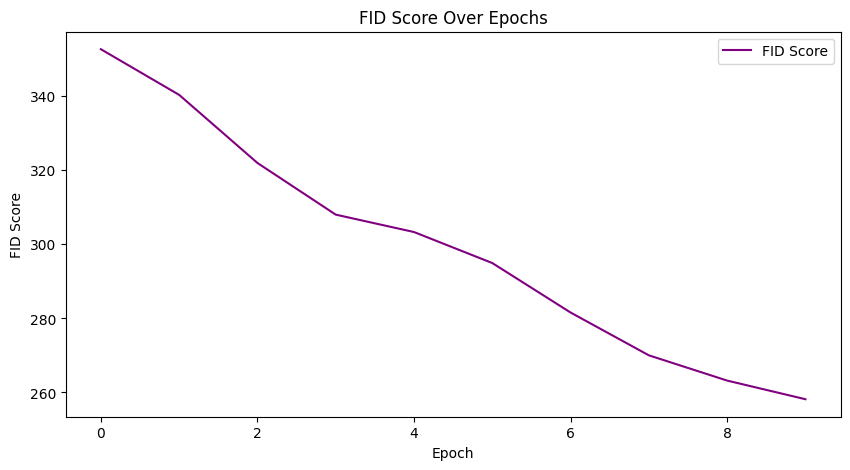

In [ ]:
# FID
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", color="purple")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.title("FID Score Over Epochs")
plt.legend()
plt.show()


In [ ]:
generator.eval()  # Set to evaluation mode
discriminator.eval()

test_dataset = datasets.CelebA(
    "../../data/celeba",
    split="test",  # Set train=False to load the test dataset
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.CenterCrop(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)


# Create the test DataLoader
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=opt.batch_size,
    shuffle=False,  # No need to shuffle the test dataset
)

all_preds = []
all_labels = []
all_validities = []

with torch.no_grad():  # Disable gradient computation for faster performance
    for imgs, labels in test_dataloader:
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # Generate predictions from discriminator
        validity, pred_labels = discriminator(real_imgs)

        # Save predictions and actual labels for evaluation
        all_preds.append(pred_labels.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_validities.append(validity.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_validities = np.concatenate(all_validities, axis=0)


# Calculate accuracy
pred_classes = np.argmax(all_preds, axis=1)
accuracy = np.mean(pred_classes == all_labels[:,attribute_index])
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test Accuracy: 88.74%


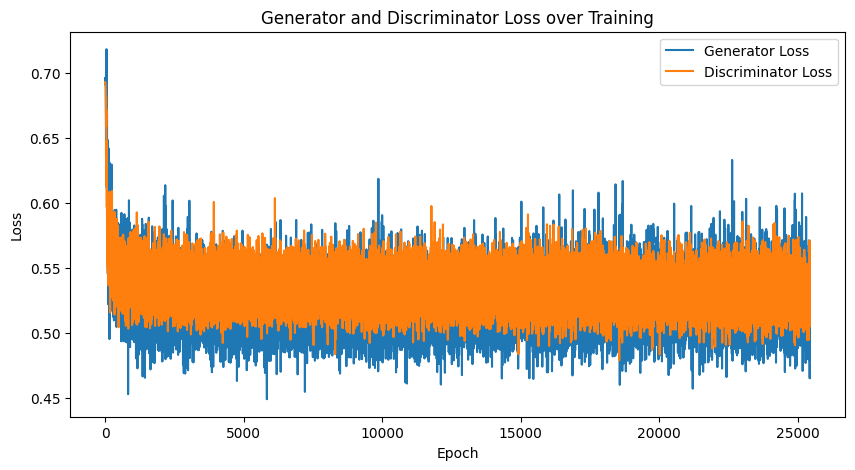

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_list, label="Generator Loss")
plt.plot(discriminator_loss_list, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss over Training")
plt.show()


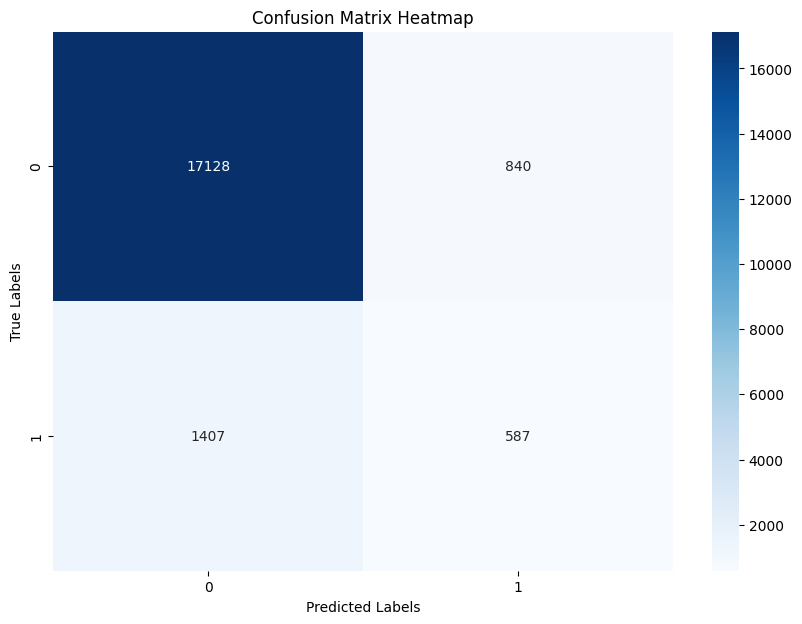

In [ ]:
#For Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming all_labels has multiple columns and attribute_index is still relevant
true_labels_single_attribute = all_labels[:, attribute_index]  # Extract the column for the specific attribute

# Compute confusion matrix
conf_mat = confusion_matrix(true_labels_single_attribute, pred_classes)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `generator` is your trained ACGAN generator model
def generate_images(generator, num_classes=10, latent_dim=100):
    plt.figure(figsize=(10, 10))
    for i in range(num_classes):
        noise = np.random.normal(0, 1, (1, latent_dim))  # Latent space noise
        label = np.array([i])  # Class label
        generated_image = generator.predict([noise, label])[0]
        plt.subplot(1, num_classes, i + 1)
        plt.imshow((generated_image + 1) / 2)  # Assuming tanh scaling
        plt.title(f"Class {i}")
        plt.axis("off")
    plt.show()

generate_images(generator)


AttributeError: 'Generator' object has no attribute 'predict'

<Figure size 1000x1000 with 0 Axes>

In [ ]:
generator

Generator(
  (label_emb): Embedding(2, 100)
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=32768, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [ ]:
discriminator

Discriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ad

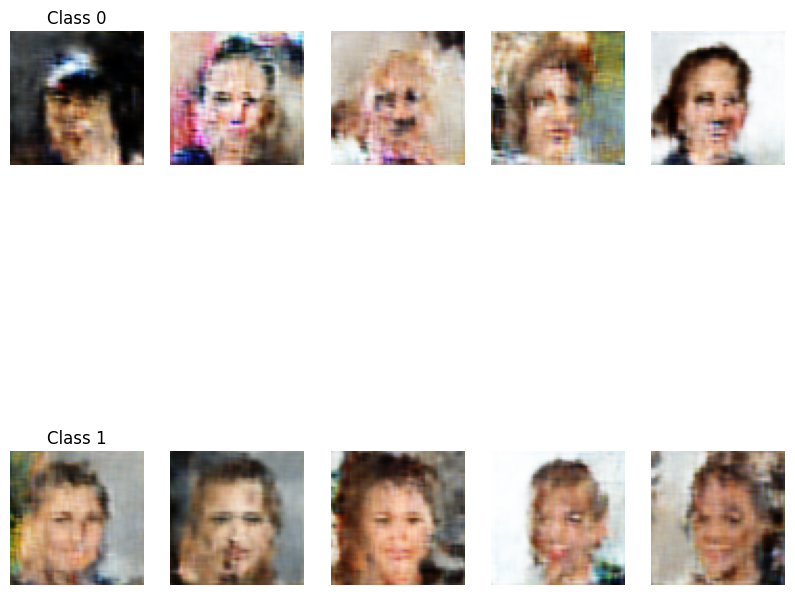

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming 'generator' is an instance of your trained generator model
# and it can be called directly (e.g., generator(noise, labels))

def generate_and_display_samples(generator, num_samples=5, label_list=[0, 1], latent_dim=100):
    """
    Generate and display samples from the ACGAN generator.

    Parameters:
    - generator: Trained generator model (callable, e.g., with __call__ or forward)
    - num_samples: Number of samples per class to generate
    - label_list: List of class labels to condition on (e.g., [0, 1] for binary classes)
    - latent_dim: Dimension of the latent noise vector
    """
    plt.figure(figsize=(num_samples * len(label_list), 2 * num_samples))

    # Set the generator to evaluation mode if using PyTorch
    generator.eval()

    device = next(generator.parameters()).device

    for i, class_label in enumerate(label_list):
        # Generate random noise
        noise = torch.randn(num_samples, latent_dim, device=device)  # Random noise vector
        # Generate class labels
        class_labels = torch.ones(num_samples, dtype=torch.long, device=device) * class_label  # Assuming labels are 1-dimensional

        # Generate images using the generator model
        with torch.no_grad():  # No need to compute gradients
            generated_images = generator(noise, class_labels)  # Forward pass through the generator

        # Convert generated images to numpy and scale to [0, 1] if needed
        generated_images = (generated_images.cpu().numpy() * 0.5 + 0.5).transpose(0, 2, 3, 1)  # Adjust shape if needed

        # Display generated images
        for j in range(num_samples):
            plt.subplot(len(label_list), num_samples, i * num_samples + j + 1)
            plt.imshow(generated_images[j])
            plt.axis('off')
            if j == 0:
                plt.title(f"Class {int(class_label)}")
    plt.show()

# Example usage:
generate_and_display_samples(generator, num_samples=5, label_list=[0, 1], latent_dim=100)
